# Import data

In [1001]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from imblearn import under_sampling, over_sampling
from sklearn.metrics import accuracy_score,ConfusionMatrixDisplay,RocCurveDisplay

from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.svm import SVC
import lightgbm as lgb
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import RandomizedSearchCV

import warnings
warnings.filterwarnings("ignore")


In [1002]:
df = pd.read_csv('dataset\Marketing Campaign\marketing_campaign.csv',sep=';')

# Pre-Processing

- Handle missing values
- Handle duplicated data
- Handle outliers
- Feature transformation
- Feature encoding
- Handle class imbalance

## Data Cleansing

### Handle missing values

In [1003]:
df.isna().sum()

ID                      0
Year_Birth              0
Education               0
Marital_Status          0
Income                 24
Kidhome                 0
Teenhome                0
Dt_Customer             0
Recency                 0
MntWines                0
MntFruits               0
MntMeatProducts         0
MntFishProducts         0
MntSweetProducts        0
MntGoldProds            0
NumDealsPurchases       0
NumWebPurchases         0
NumCatalogPurchases     0
NumStorePurchases       0
NumWebVisitsMonth       0
AcceptedCmp3            0
AcceptedCmp4            0
AcceptedCmp5            0
AcceptedCmp1            0
AcceptedCmp2            0
Complain                0
Z_CostContact           0
Z_Revenue               0
Response                0
dtype: int64

In [1004]:
df.shape

(2240, 29)

In [1005]:
#persentasi missing data
percent_na = (df.isna().sum().sum())/(df.shape[0])*100
print(f'{round(percent_na,2)}%')

1.07%


In [1006]:
#Karena missing value sekitar 1% dari dataset kita akan drop
df = df.dropna(axis=0)

Missing value hanya terdapat pada kolom income dengan jumlah 24, nilai ini cenderung kecil dibandingkan dengan keseluruhan data (2240) sehingga diperkirakan tidak akan berpengaruh pada model. Dengan presentase 1% missing terhadap total data maka akan didrop.


### Handle duplicated data

In [1007]:
df.duplicated().sum()

0

Tidak terdapat data duplicate pada dataset

### Handle outliers

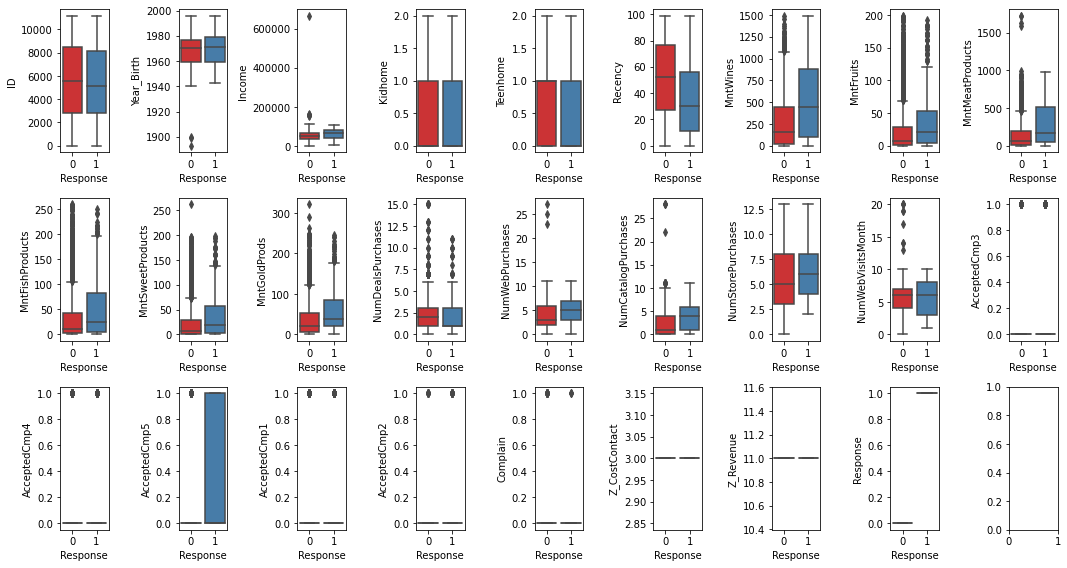

In [1008]:
dft = df.copy()
num = [i for i in df.columns if df[i].dtype != 'object']

fig, ax = plt.subplots(3,9,figsize=(15,8))

a=0
b=0
for i in num:
    sns.boxplot(data=dft,y=i,x='Response',ax=ax[a,b],palette='Set1')
    b += 1
    if b == 9:
        a += 1
        b = 0

plt.tight_layout()
plt.show()

In [1009]:
#Terdapat outliers yang sangat ekstrem pada kolom Income dan Year_Birth sehinggal akan kita handling outliers ini dengan IQR

df_before = df[['Year_Birth','Income','Response']].copy() #DataFrame Sebagai perbandingan

outliers_ = ['Year_Birth','Income'] #List outliers

def handling_outliers(x):
    global df
    q1 = df[x].quantile(0.25)
    q3 = df[x].quantile(0.75)
    iqr = q3 - q1
    low_lim = q1 - (1.5 * iqr)
    hi_lim = q3 + (1.5 * iqr)
    filterred = ((df[x]>=low_lim)&(df[x]<=hi_lim))
    df = df[filterred]
    
for i in outliers_:
    handling_outliers(i)

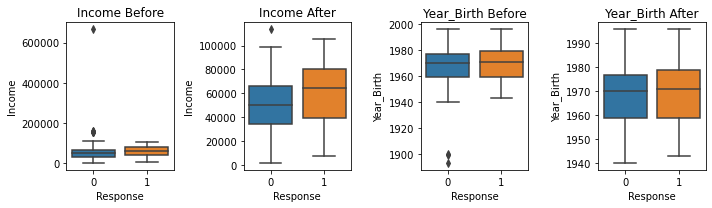

In [1010]:
fig, ax = plt.subplots(1,4,figsize=(10,3))
sns.boxplot(data=df_before,y='Income',x='Response',ax=ax[0])
ax[0].set_title('Income Before')
sns.boxplot(data=df,y='Income',x='Response',ax=ax[1])
ax[1].set_title('Income After')
sns.boxplot(data=df_before,y='Year_Birth',x='Response',ax=ax[2])
ax[2].set_title('Year_Birth Before')
sns.boxplot(data=df,y='Year_Birth',x='Response',ax=ax[3])
ax[3].set_title('Year_Birth After')

plt.tight_layout()
plt.show()

Outlier yang sangat eksterm terdapat di kolom Income dan Year_Birth sehingga akan kita handel dengan menggunakan IQR. Pada kolom lainnya terdapat beberapa outlier yang dinilai tidak terlalu ekstrem sehinggal tidak kita handling.
- tanyain ini kan termasuk data testing nantinya?

### Feature transformation

#### Log Transformation
Dilakukan transformasi log(x + 1), karena jika log(x) saja pada nilai values 0 akan menghasilkan nilai infinity
- copy mnt columns dan num columns buat feature extraction

##### Mnt columns

In [1011]:
#Dari boxplot sebelumnya sebaran data MntProducts terlihat positive skewed, kita lakukan log transformation
trans_col_mnt = ['MntWines', 'MntFruits', 'MntMeatProducts', 'MntFishProducts','MntSweetProducts', 'MntGoldProds']
trans_col_mnt_log = ['MntWines_log', 'MntFruits_log', 'MntMeatProducts_log', 'MntFishProducts_log',
                     'MntSweetProducts_log', 'MntGoldProds_log']

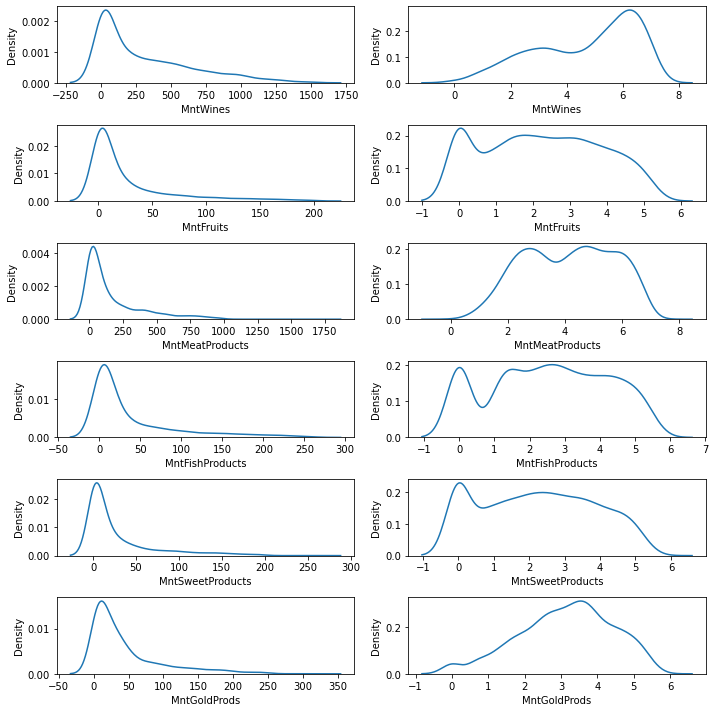

In [1012]:
#Transformasi log(x + 1) dengan menambahkan kolom baru
df[trans_col_mnt_log] = np.log(df[trans_col_mnt] + 1)

#Perbandingan sebelum log dan setelah log
def histo(x):
    fig, ax = plt.subplots(len(x),2,figsize=(10,10))
    for i in range(0,len(x)):
        sns.kdeplot(df[x[i]],ax=ax[i,0])
        sns.kdeplot(np.log(df[x[i]]+1),ax=ax[i,1])
        
    plt.tight_layout()
    plt.show()
histo(trans_col_mnt)

In [1013]:
#Transformasi log(x + 1) dengan menambahkan kolom baru
df[trans_col_mnt_log] = np.log(df[trans_col_mnt] + 1)

In [1014]:
df[trans_col_mnt + trans_col_mnt_log].describe()

,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,MntWines_log,MntFruits_log,MntMeatProducts_log,MntFishProducts_log,MntSweetProducts_log,MntGoldProds_log
count,2205.000000,2205.000000,2205.000000,2205.000000,2205.000000,2205.000000,2205.000000,2205.000000,2205.000000,2205.000000,2205.000000,2205.000000
mean,306.164626,26.403175,165.312018,37.756463,27.128345,44.057143,4.686567,2.247012,4.131120,2.542396,2.247480,3.128769
std,337.493839,39.784484,217.784507,54.824635,41.130468,51.736211,1.801605,1.569506,1.554547,1.658386,1.592604,1.283472
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,24.000000,2.000000,16.000000,3.000000,1.000000,9.000000,3.218876,1.098612,2.833213,1.386294,0.693147,2.302585
50%,178.000000,8.000000,68.000000,12.000000,8.000000,25.000000,5.187386,2.197225,4.234107,2.564949,2.197225,3.258097
75%,507.000000,33.000000,232.000000,50.000000,34.000000,56.000000,6.230481,3.526361,5.451038,3.931826,3.555348,4.043051
max,1493.000000,199.000000,1725.000000,259.000000,262.000000,321.000000,7.309212,5.298317,7.453562,5.560682,5.572154,5.774552


##### Num Columns

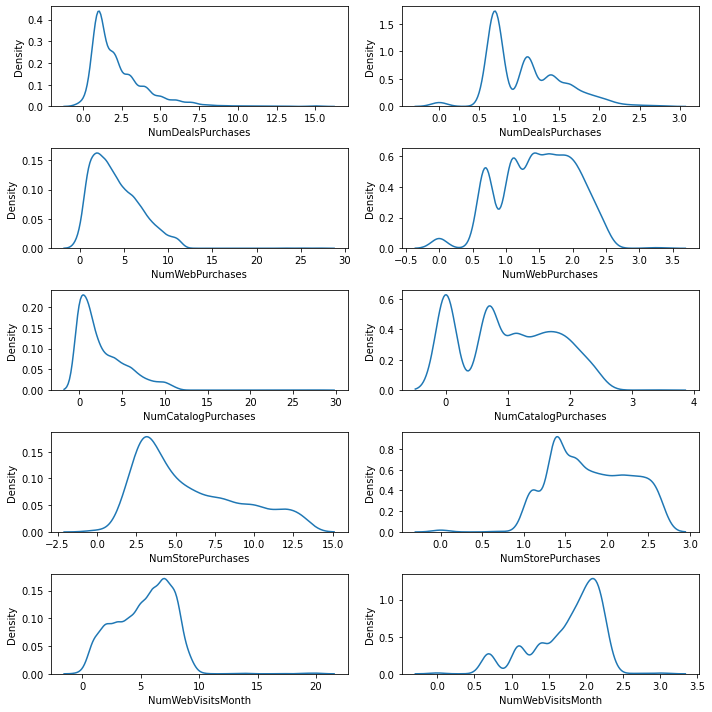

In [1015]:
#Dari boxplot sebelumnya sebaran data NumPurchases terlihat positive skewed, kita lakukan coba lakukan log transformation
num_col = ['NumDealsPurchases', 'NumWebPurchases', 'NumCatalogPurchases', 'NumStorePurchases', 'NumWebVisitsMonth']
histo(num_col)

Num columns tidak kita lakukan log transformation karena cenderung tidak terlalu skewed

#### Normalization
Kita aplikasikan Normalizaton kepada semua numerical kolom kecuali kolom Year_Birth,Kidhome,Teenhome, dan family Num columns yang akan kita lakukan Feature extraction terlebih dahulu

In [1016]:
num_col_norm = ['NumDealsPurchases_norm', 'NumWebPurchases_norm', 'NumCatalogPurchases_norm', 'NumStorePurchases_norm',
                 'NumWebVisitsMonth_norm']
df[num_col_norm] = df[num_col]

norm_col = [i for i in df.columns if df[i].dtype != 'object']

exceptions_ = ['Year_Birth','Kidhome','Teenhome'] + num_col
for i in exceptions_:
    norm_col.remove(i)
norm_col

['ID',
 'Income',
 'Recency',
 'MntWines',
 'MntFruits',
 'MntMeatProducts',
 'MntFishProducts',
 'MntSweetProducts',
 'MntGoldProds',
 'AcceptedCmp3',
 'AcceptedCmp4',
 'AcceptedCmp5',
 'AcceptedCmp1',
 'AcceptedCmp2',
 'Complain',
 'Z_CostContact',
 'Z_Revenue',
 'Response',
 'MntWines_log',
 'MntFruits_log',
 'MntMeatProducts_log',
 'MntFishProducts_log',
 'MntSweetProducts_log',
 'MntGoldProds_log',
 'NumDealsPurchases_norm',
 'NumWebPurchases_norm',
 'NumCatalogPurchases_norm',
 'NumStorePurchases_norm',
 'NumWebVisitsMonth_norm']

In [1017]:
for i in norm_col:
    df[i] = MinMaxScaler().fit_transform(df[i].values.reshape(len(df),1))

In [1018]:
df[num_col_norm + num_col].describe()

,NumDealsPurchases_norm,NumWebPurchases_norm,NumCatalogPurchases_norm,NumStorePurchases_norm,NumWebVisitsMonth_norm,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth
count,2205.000000,2205.000000,2205.000000,2205.000000,2205.000000,2205.000000,2205.000000,2205.000000,2205.000000,2205.000000
mean,0.154558,0.151877,0.094477,0.447968,0.266848,2.318367,4.100680,2.645351,5.823583,5.336961
std,0.125740,0.101386,0.099952,0.249369,0.120677,1.886107,2.737424,2.798647,3.241796,2.413535
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.066667,0.074074,0.000000,0.230769,0.150000,1.000000,2.000000,0.000000,3.000000,3.000000
50%,0.133333,0.148148,0.071429,0.384615,0.300000,2.000000,4.000000,2.000000,5.000000,6.000000
75%,0.200000,0.222222,0.142857,0.615385,0.350000,3.000000,6.000000,4.000000,8.000000,7.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,15.000000,27.000000,28.000000,13.000000,20.000000


### Feature encoding
Kita lakukan label encode(LE) dan One Hot Encoding(OHE) pada Education dan OHE pada Marital_Status

In [1019]:
#Kriteria LE
edu = {'Basic':0,'Graduation':1,'2n Cycle':2,'Master':3,'PhD':4}

In [1020]:
#OHE
cat = ['Education', 'Marital_Status']
df_OHE = pd.get_dummies(df[cat])
df = pd.concat([df,df_OHE],axis=1)

In [1021]:
#LE
df['Education_LE'] = df['Education'].map(edu)
df.head(3)

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,...,Education_PhD,Marital_Status_Absurd,Marital_Status_Alone,Marital_Status_Divorced,Marital_Status_Married,Marital_Status_Single,Marital_Status_Together,Marital_Status_Widow,Marital_Status_YOLO,Education_LE
0,0.493611,1957,Graduation,Single,0.503625,0,0,2012-09-04,0.585859,0.425318,...,0,0,0,0,0,1,0,0,0,1
1,0.194263,1954,Graduation,Single,0.398325,1,1,2014-03-08,0.383838,0.007368,...,0,0,0,0,0,1,0,0,0,1
2,0.370029,1965,Graduation,Together,0.623933,0,0,2013-08-21,0.262626,0.285332,...,0,0,0,0,0,0,1,0,0,1


In [1022]:
#Kita drop kolom yang telah diOHE
df = df.drop(columns=cat, axis=1)

### Handle class imbalance
Kita akan gunakan imblearn SMOTE untuk menyeimbangkan data target

In [1023]:
#Train data dan test data
X = df.copy()
y = X.pop('Response')

print('Bentuk data', X.shape)

Bentuk data (2205, 51)


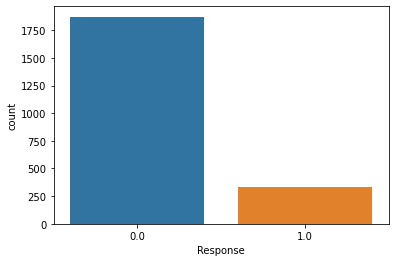

In [1024]:
sns.countplot(y)
plt.show()

Data target tidak seimbang

In [1025]:
#kolom Dt_Customer akan kita drop karena tidak bisa digunakan untuk SMOTE dan juga tidak memiliki korelasi terhadap target
X = X.drop(columns='Dt_Customer', axis=1) #drop karena tidak releval dengan target 

#Handling Imbalance
X_SMOTE, y_SMOTE = over_sampling.SMOTE().fit_resample(X,y)

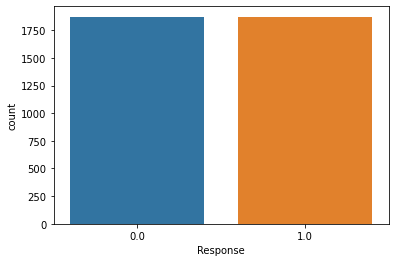

In [1026]:
sns.countplot(y_SMOTE)
plt.show()

In [1027]:
X=X_SMOTE.copy()
y=y_SMOTE.copy()

In [1028]:
X.head()

,ID,Year_Birth,Income,Kidhome,Teenhome,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,...,Education_PhD,Marital_Status_Absurd,Marital_Status_Alone,Marital_Status_Divorced,Marital_Status_Married,Marital_Status_Single,Marital_Status_Together,Marital_Status_Widow,Marital_Status_YOLO,Education_LE
0,0.493611,1957,0.503625,0,0,0.585859,0.425318,0.442211,0.316522,0.664093,...,0,0,0,0,0,1,0,0,0,1
1,0.194263,1954,0.398325,1,1,0.383838,0.007368,0.005025,0.003478,0.007722,...,0,0,0,0,0,1,0,0,0,1
2,0.370029,1965,0.623933,0,0,0.262626,0.285332,0.246231,0.073623,0.428571,...,0,0,0,0,0,0,1,0,0,1
3,0.552408,1984,0.222456,1,0,0.262626,0.007368,0.020101,0.011594,0.038610,...,0,0,0,0,0,0,1,0,0,1
4,0.475739,1981,0.505009,1,0,0.949495,0.115874,0.216080,0.068406,0.177606,...,1,0,0,0,1,0,0,0,0,4


In [1029]:
y.head()

0    1.0
1    0.0
2    0.0
3    0.0
4    0.0
Name: Response, dtype: float64

In [1030]:
print('Bentuk data',X.shape)

Bentuk data (3744, 50)


In [1031]:
df = pd.concat([X,y],axis=1)

In [1032]:
df.head()

,ID,Year_Birth,Income,Kidhome,Teenhome,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,...,Marital_Status_Absurd,Marital_Status_Alone,Marital_Status_Divorced,Marital_Status_Married,Marital_Status_Single,Marital_Status_Together,Marital_Status_Widow,Marital_Status_YOLO,Education_LE,Response
0,0.493611,1957,0.503625,0,0,0.585859,0.425318,0.442211,0.316522,0.664093,...,0,0,0,0,1,0,0,0,1,1.0
1,0.194263,1954,0.398325,1,1,0.383838,0.007368,0.005025,0.003478,0.007722,...,0,0,0,0,1,0,0,0,1,0.0
2,0.370029,1965,0.623933,0,0,0.262626,0.285332,0.246231,0.073623,0.428571,...,0,0,0,0,0,1,0,0,1,0.0
3,0.552408,1984,0.222456,1,0,0.262626,0.007368,0.020101,0.011594,0.038610,...,0,0,0,0,0,1,0,0,1,0.0
4,0.475739,1981,0.505009,1,0,0.949495,0.115874,0.216080,0.068406,0.177606,...,0,0,0,1,0,0,0,0,4,0.0


Data target sudah balance dengan penambahan sekitar 1500 rows baru.

## Feature Engineering

### Feature Selection
- kolom ID kita drop karena tidak relevan terhadap target
- kolom Z_CostContact dan Z_Revenue kita drop karena merupakan konstanta yang tidak mempengaruhi target

In [1033]:
df = df.drop(columns=['ID','Z_CostContact','Z_Revenue'])

### Feature extraction

**Ini hanya gambaran aja ya guys**<br>
- Kolom Year_Birth dapat kita ubah menjadi kolom age untuk memudahkan pengamatan
- Kolom Kidhome dan Teenhome dapat kita transformasi menjadi kolom child karena kedua kolom ini memeliki hubungan yang sama terhadap response
- Kolom monetary dari kolom Mnt family
- Kolom frequency dari kolom Num family

In [1034]:
#Check apakah Kolom memiliki keterikatan seperti jika Teenhome > 0 maka Kidhome != 0
df[(df['Kidhome']==0) & (df['Teenhome']!=0)].head(3)

,Year_Birth,Income,Kidhome,Teenhome,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,...,Marital_Status_Absurd,Marital_Status_Alone,Marital_Status_Divorced,Marital_Status_Married,Marital_Status_Single,Marital_Status_Together,Marital_Status_Widow,Marital_Status_YOLO,Education_LE,Response
5,1967,0.542686,0,1,0.161616,0.348292,0.211055,0.056812,0.00000,0.160305,...,0,0,0,0,0,1,0,0,3,0.0
6,1971,0.481277,0,1,0.343434,0.157401,0.326633,0.095072,0.19305,0.187023,...,0,0,1,0,0,0,0,0,1,0.0
17,1949,0.671985,0,1,0.919192,0.677830,0.402010,0.288696,0.00000,0.061069,...,0,0,0,1,0,0,0,0,3,0.0


In [1035]:
#Buat kolom baru childs
df['childs'] = df['Kidhome'] + df['Teenhome']

#Drop kolom Kidhome dan Teenhome
df = df.drop(columns=['Kidhome','Teenhome'], axis=1)

In [1036]:
#Buat kolom age
df['age'] = 2020 - df['Year_Birth']

#Drop kolom Year_Birth
df = df.drop(columns='Year_Birth', axis=1)

In [1037]:
#Normalisasi kolom baru
for i in ['childs','age']:
    df[i] = MinMaxScaler().fit_transform(df[i].values.reshape(len(df),1))

In [1038]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Income,3744.0,0.479092,0.197655,0.0,0.313526,0.484719,0.655314,1.0
Recency,3744.0,0.437655,0.275696,0.0,0.200820,0.404361,0.648848,1.0
MntWines,3744.0,0.262224,0.253434,0.0,0.023367,0.187804,0.450480,1.0
MntFruits,3744.0,0.157288,0.207950,0.0,0.015075,0.065327,0.220329,1.0
MntMeatProducts,3744.0,0.128643,0.145749,0.0,0.013333,0.062609,0.212877,1.0
MntFishProducts,3744.0,0.170912,0.217326,0.0,0.015444,0.065637,0.258911,1.0
MntSweetProducts,3744.0,0.120664,0.157285,0.0,0.010736,0.051778,0.177691,1.0
MntGoldProds,3744.0,0.161916,0.163467,0.0,0.043614,0.105299,0.230701,1.0
NumDealsPurchases,3744.0,2.150908,1.856726,0.0,1.000000,1.000000,3.000000,15.0
NumWebPurchases,3744.0,4.325053,2.614997,0.0,2.000000,4.000000,6.000000,27.0
